In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
from scipy import signal
from scipy import interpolate
import os
import pytz
import time
import re

/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


# Telescope Dimensions

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

# Define Aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2) #slightly oversized because GPI does not correct teh boundaries well
ap_inner = (ar <= 1.5/2)   

#ap_outer = (ar <= outD/2)
#ap_inner = (ar <= inD/2)   
ap = (ap_outer ^ ap_inner).astype(np.float)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

# Make the spatial freq grid

Will use to plot against spatial PSDs

In [4]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

# Phase Sample

1. name_list - list containing telemetry date strings
2. fname_list - list containing path to telemetry files

In [5]:
def path_manager(desktop_name):
    
    if desktop_name == 'gpi_cruncher':
        rootdir = '/home/sda/mtallis/PhaseScripts/aotelem/Reduced/'
        save_path = '/home/sda/mtallis/Results/c_Eri/'
        samples_path = '/home/sda/mtallis/samples/c_Eri_samples.txt'
    
    if desktop_name == 'kipac':
        rootdir = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Results/c_Eri/'
        save_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Results/c_Eri/'
        samples_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/datatables/c_Eri_samples.txt'
        
    if desktop_name == 'laptop':
        rootdir = '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/Results/c_Eri/'
        save_path = '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/Results/c_Eri/'
        samples_path = '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/Results/c_Eri/c_Eri_samples.txt'

    dstr = time.strftime('%Y%m%d')
    return rootdir,save_path, samples_path, dstr

In [6]:
rootdir, save_path, samples_path, dstr = path_manager('kipac')

In [7]:
with open(samples_path,'r') as f:
    sample = f.read().splitlines() #outputs as a list of strings

Only use with gpi cruncher when images need to be processed

In [ ]:
fname_list = list()
name_list = list()

for i in sample:
    for root, dirs, files in os.walk(rootdir):
        for name in files:
            (base,ext) = os.path.splitext(name)
            if (ext in ('.fits')) and (i in base):
                full_name = os.path.join(root,name)
                #print(full_name)
                fname_list.append(full_name)  
                name_list.append(base[11:-12])

# Analysis Functions

1. processs_phase - Imports .fits & removes static aberrations in each phase  
2. radialProfile - Computes mean inside each radial bin starting from center
3. sp_power_spec - Computes time average of 2d DFT^2  
4. temp_power_spec - Computes actuator timeseries DFT^2 and averages over aperture
5. linear fit - fits a power law to psd. Behaves like a line in loglog space

In [8]:
def process_phase(filepath):

    hdulist = fits.open(filepath,memmap=True)
    phase = hdulist[0].data.astype('float')
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 

    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    return c_phase

In [9]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

In [10]:
def sp_power_spec(phase):    
    
    timesteps, phx, phy = phase.shape 
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    for t in np.arange(timesteps):
        phFT[t,:,:] = fft.fftshift(fft.fft2(phase[t,:,:]))*2.0/ap.sum()
    print('Done with FT')
    
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.square(np.abs(phFT[:,k,l]))
    
    avg_psd2D = np.mean(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    
    return avg_psd1D

In [11]:
def temp_power_spec(Y,sample_spacing):
    
    n = len(Y)
    dT = sample_spacing

    w = signal.blackman(n)
    P = np.fft.rfft(Y*w)
    norm = 1000.0/n
    P = P * norm

    P2 = np.square(np.abs(P))
    #k = np.fft.rfftfreq(n,dT)
    
    return P2

In [13]:
def linear_fit(Y,k,lb,up,param):
    
    if param == 'space':
        par = np.polyfit(np.log10(k[(k>lb) & (k<up)]), np.log10(Y[(k>lb) & (k<up)]), 1)
        
    if param == 'time':
        Y = Y.dropna()
        n = Y.size
        dT = .001
        k = np.fft.fftfreq(n,dT)
        par = np.polyfit(np.log10(k[(k>lb) & (k<up)]), np.log10(Y[(k>lb) & (k<up)]), 1)

    slope = par[0]
    intercept = par[1]
    return slope,intercept    

# Perform Analysis 

Define spatial frequencies (34 bins)

In [17]:
k = radialProfile(kr)

Store spatial PSD values in DataFrame for later analysis

In [ ]:
df_sp_psd = pd.DataFrame(columns = name_list)

i=0
for file in fname_list:
    print(file)
    print(name_list[i])
    y_2D = process_phase(file)
    y_psd = sp_power_spec(y_2D)
    df_sp_psd[name_list[i]] = y_psd
    i=i+1

In [ ]:
df_sp_psd.to_csv(save_path+'sp_psd'+'_'+dstr+'.txt')

Store temporal PSD values in DataFrame for later analysis.
Key = 'telemetry date'
columns = 'kt' & 't_psd' (Note varying timeseries lengths) 

In [ ]:
df_t_psd = pd.DataFrame()

i=0
for file in fname_list[0:2]:
    y_2D = process_phase(file)
    y_1D = np.mean(y_2D,axis=(1,2))
    y_psd = temp_power_spec(y_1D,.001)
    y_smoothed = 10**signal.savgol_filter(np.log10(y_psd), 101, 5)
    #df_t_psd[name_list[i],'dts'] = pd.to_datetime(name_list[i],format='%Y.%m.%d_%H.%M.%S',utc=True)
    new_df = pd.DataFrame({name_list[i]:y_smoothed})
    df_t_psd = pd.concat([df_t_psd,new_df],axis=1)
    print(name_list[i])
    i=i+1

In [ ]:
df_t_psd

In [ ]:
%matplotlib notebook

df_t_psd['kt'] = np.fft.fftfreq(len(df_t_psd),.001)
df_t_psd.plot(logx=True,logy=True)

In [ ]:
df_t_psd.to_csv(save_path+'t_psd'+'_'+dstr+'.txt')

# Grouping of samples 

read in spatial or temporal psd samples

In [14]:
df_sp_psd = pd.read_csv(save_path+'sp_psd_20190312.txt',index_col=0)
df_t_psd = pd.read_csv(save_path+'t_psd_20190312.txt',index_col=0)

Put dates into night groups

In [ ]:
df = pd.DataFrame({'fname_list':fname_list,'name_list':name_list})
df['dts'] = pd.to_datetime(df['name_list'],format='%Y.%m.%d_%H.%M.%S',utc=True)
df['delta_t'] = df['dts']-df['dts'].shift(1)
df.loc[0,'delta_t'] = pd.Timedelta(0)

def bin_f(row):
    if row['delta_t'] > pd.Timedelta('20H'):
        return row['dts'].date()
    
df['bin']=df.apply(bin_f,axis = 1)
df.loc[0:1,'bin']=df.loc[0,'dts'].date()
df['bin']=df['bin'].fillna(method='ffill')
g_df = df.groupby('bin')

Create a dataframe with the average psd measured in each night window. Column names contain date at the start of the night 

In [ ]:
df_avg_sp_psd = pd.DataFrame()

for name,group in g_df:
    df_avg_sp_psd.loc[:,str(name)] = df_sp_psd.loc[:,group['name_list'].tolist()].mean(axis=1)

In [ ]:
df_avg_sp_psd.to_csv(save_path+'avg_sp_psd_'+dstr+'.txt')

In [ ]:
df_avg_t_psd = pd.DataFrame()

for name,group in g_df:
    df_avg_t_psd.loc[:,str(name)] = df_t_psd.loc[:,group['name_list'].tolist()].mean(axis=1)

In [ ]:
df_avg_t_psd.to_csv(save_path+'avg_t_psd_'+dstr+'.txt')

# Read in avg psd dataframes

In [15]:
df_avg_sp_psd = pd.read_csv(save_path+'avg_sp_psd_20190312.txt',index_col=0)
df_avg_t_psd = pd.read_csv(save_path+'avg_t_psd_20190312.txt',index_col=0)

In [18]:
df_avg_t_psd['kt'] = np.fft.fftfreq(len(df_avg_t_psd),.001)
df_avg_sp_psd['ks'] = radialProfile(kr)

# Fit power law to avg PSDs

In [21]:
df_linear_fit_psd = pd.DataFrame(columns=['sp_psd','t_psd'])
df_linear_fit_psd['sp_psd'] = df_avg_sp_psd.apply(linear_fit, k=df_avg_sp_psd['ks'],lb = (1/3.0), up = 1.0, param='space',axis = 0)

In [22]:
df_linear_fit_psd['t_psd'] = df_avg_t_psd.apply(linear_fit, k=None, lb = 2.0, up = 40.0, param='time',axis = 0)

In [36]:
df_linear_fit_psd

,sp_psd,t_psd
2014-12-17,"(-3.60176043792, -2.45297520421)","(-3.15170880988, 2.42838965845)"
2015-01-28,"(-3.39662422959, -2.2002902673)","(-2.90070828164, 1.5353589102)"
2015-01-29,"(-3.49730036598, -2.27651657944)","(-3.37441294778, 2.23365746236)"
2015-01-30,"(-3.69114069193, -2.01809950107)","(-2.94084054216, 2.0348787941)"
2015-08-30,"(-3.53105670089, -2.21019057607)","(-3.37281744397, 3.12165815948)"
2015-08-31,"(-3.62302397091, -1.93993271819)","(-3.37308217591, 2.65859721662)"
2015-09-01,"(-3.62807288109, -2.1613937795)","(-3.23005438485, 1.97613415125)"
2015-11-05,"(-3.57519398253, -1.8790939888)","(-3.22851513228, 2.50357629107)"
2015-12-17,"(-3.52674816974, -1.96602220102)","(-3.16317735527, 1.91068935733)"
2015-12-19,"(-3.53761989048, -1.8987427304)","(-3.09063813799, 1.71683475933)"


In [23]:
df_linear_fit_psd.loc[['2016-09-18','2016-09-21']]

,sp_psd,t_psd
2016-09-18,"(-3.65142239996, -2.28154324188)","(-3.49373788529, 2.67249080127)"
2016-09-21,"(-3.41263709093, -2.01564255679)","(-2.98146613397, 2.06665957955)"


# Plot PSDs

In [24]:
m_sp_2016_09_18, int_sp_2016_09_18 = df_linear_fit_psd.loc[['2016-09-18']]['sp_psd'][0]
m_sp_2016_09_21, int_sp_2016_09_21 = df_linear_fit_psd.loc[['2016-09-21']]['sp_psd'][0]
m_t_2016_09_18, int_t_2016_09_18 = df_linear_fit_psd.loc[['2016-09-18']]['t_psd'][0]
m_t_2016_09_21, int_t_2016_09_21 = df_linear_fit_psd.loc[['2016-09-21']]['t_psd'][0]

In [25]:
kt = df_avg_t_psd['kt']

<IPython.core.display.Javascript object>


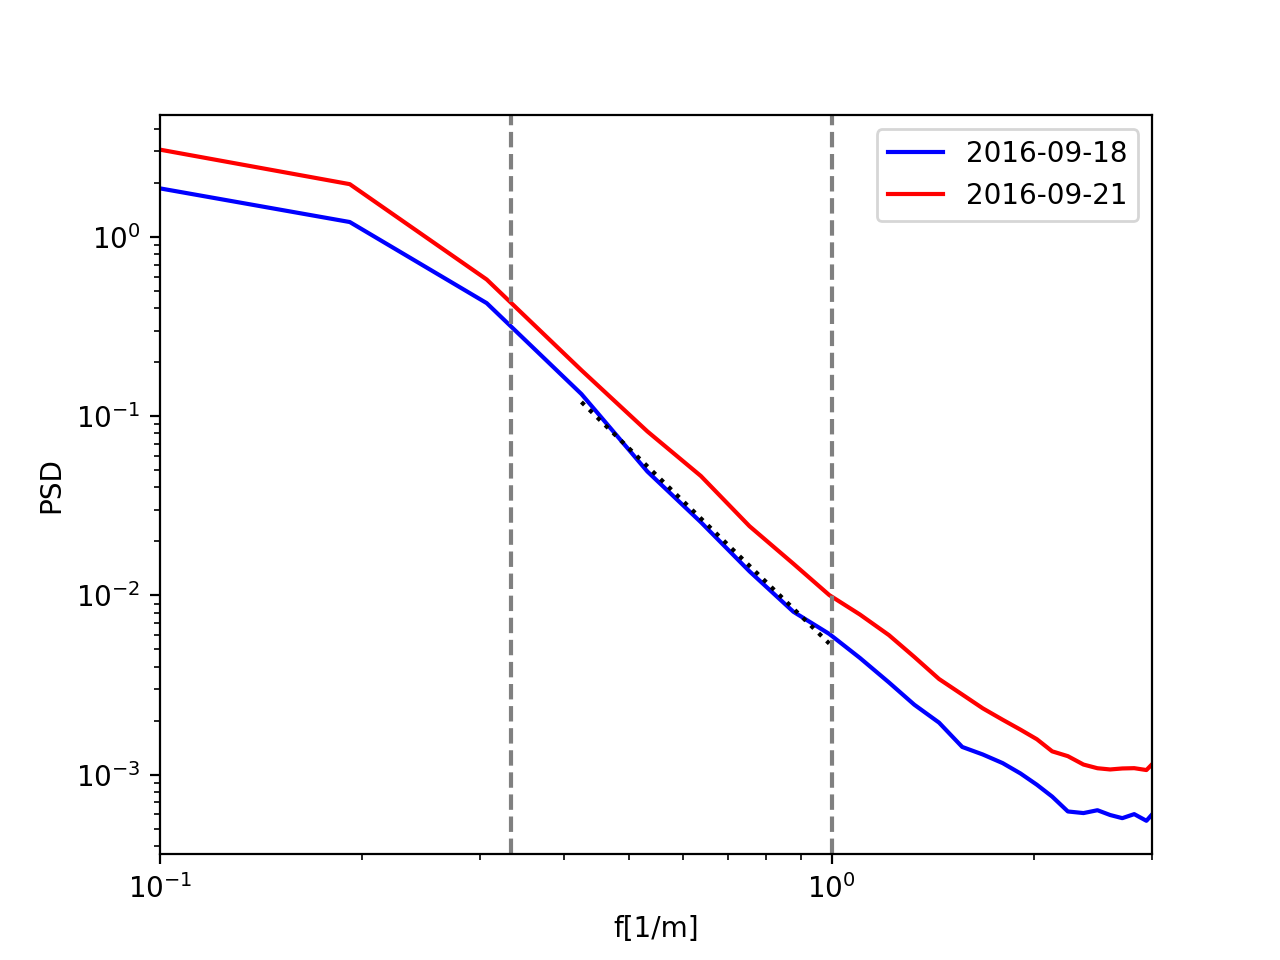

<IPython.core.display.Javascript object>


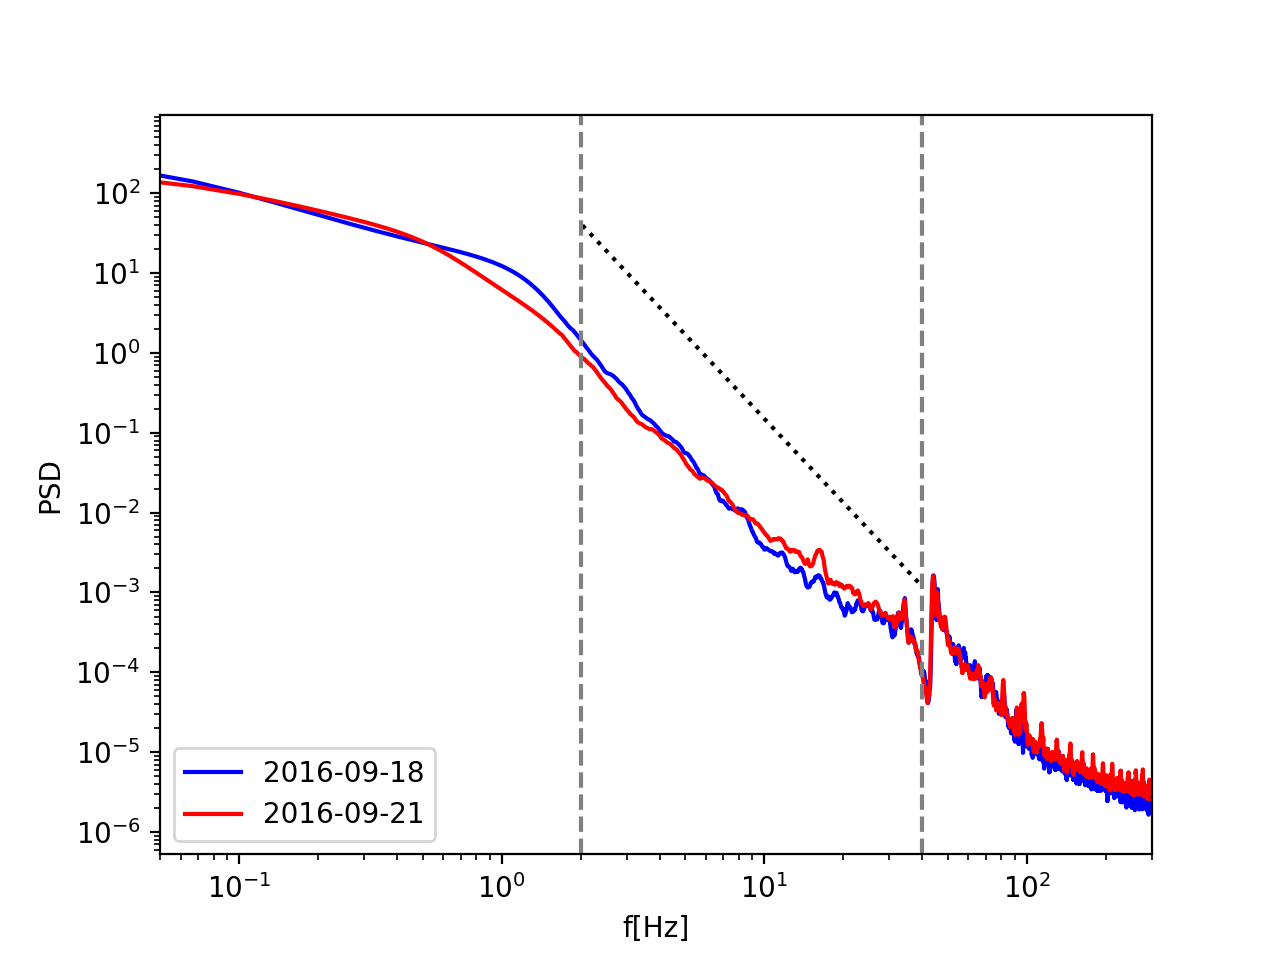

(0.05, 300)

In [80]:
%matplotlib notebook

df_avg_sp_psd.loc[:,['ks','2016-09-18','2016-09-21']].plot(x='ks',logx=True,logy=True,cmap=plt.cm.bwr)
plt.loglog(k[(k>(1./3.0)) & (k<1./(1.0))], (10**int_sp_2016_09_18)*k[(k>(1./3.0)) & (k<1./(1.0))]**m_sp_2016_09_18,'k:')
#plt.loglog(k, 10**(int_sp_2016_09_18)*k**-3.67,color='grey',linestyle='--')
plt.xlim(.1,3)
plt.axvline(x=1/3.,c='grey',linestyle = '--')
plt.axvline(x=1,c='grey',linestyle = '--')
plt.xlabel('f[1/m]')
plt.ylabel('PSD')

df_avg_t_psd.loc[:,['kt','2016-09-18','2016-09-21']].plot(x='kt',logx=True,logy=True,cmap=plt.cm.bwr)
plt.loglog(kt[(kt>2) & (kt<40)], 10**(int_t_2016_09_18)*kt[(kt>2) & (kt<40)]**m_t_2016_09_18,'k:')
#plt.loglog(kt, (10**int_t_2016_09_18)*kt**-3.67,color='grey',linestyle='--')

plt.axvline(x=2,c='grey',linestyle = '--')
plt.axvline(x=40,c='grey',linestyle = '--')
plt.xlabel('f[Hz]')
plt.ylabel('PSD')
plt.xlim(.05,300)





Plotting of PSDs

In [ ]:
m, intercept = linear_fit(kt,y_smoothed,time = True, space = False)
plt.loglog(kt,y_smoothed, label = name_list[i])
plt.loglog(kt[kt>1.0], (10**intercept)*kt[kt>1.]**-1*m)

plt.grid(axis='both')
plt.axvline(x=1)
plt.legend()

# Quick check of standard deviation

In [ ]:
for file in fname_list:
    y_2D = process_phase(file)